# Predicting Burlington Housing Prices
### Bryant Crocker 

This analysis pulls data from Burlington's open data socrata page.  I am interested in predicted the value of a single family and residential condo homes.  These are two most frequently sold types of property and tend to be the property category the realtors are most concerned with.  A pricing algorithm will help analysts to value properties and cut down the time required to get a house on the market.

### Import necessary libraries

In [1]:
#for tablular data managment 
import pandas as pd 
#for scientific plotting 
import seaborn as sns 
import matplotlib.pyplot as plt
#pythons premiere numerical computing library 
import numpy as np
plt.style.use('classic')

% matplotlib inline

### Import data and do some basic preprocessing.

In [2]:
#Read in csv from Burlington Open data
df = pd.read_csv("https://opendata.arcgis.com/datasets/276ccff527454496ac940b60a2641dda_0.csv")
#Split the 'PropertyCenterPoint' column into 'Latitude' and 'Longitude' in a seperate dataframe
df2 = df['PropertyCenterPoint'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Latitude', 1:'Longitude'})
df3 = df['Baths'].str.split('/', expand=True).rename(columns={0:'Full_Baths', 1:'Half_Baths'})
# create a dataframe with the new variables
df = pd.concat([df, df2, df3],axis=1)
df['Half_Baths'] = pd.to_numeric(df['Half_Baths'])
df['Full_Baths'] = pd.to_numeric(df['Full_Baths'])
df.head()


,AccountNumber,ParcelID,SpanNumber,StreetNumber,AlternateNumber,StreetName,Unit,CuO1LastName,CuO1FirstName,CuO2LastName,...,NumofUnits,ZoningCode,Foundation,Depreciation,PropertyCenterPoint,FID,Latitude,Longitude,Full_Baths,Half_Baths
0,6377,045-4-026-000,114-035-16377,29,NaN,MANSFIELD AV,NaN,AMERICAN NATIONAL RED CROSS,NaN,NORTHERN VT CHAPTER,...,1,I,BS,0.300,"(-73.1993, 44.48146)",1001,-73.1993,44.48146,1,1
1,8529,053-3-162-000,114-035-18529,148,NaN,LOCUST TR,NaN,NAUGHTON,ANDREW J,SAMUELS,...,1,RL,C,0.300,"(-73.2126, 44.4648)",1002,-73.2126,44.4648,1,0
2,7207,049-3-005-000,114-035-17207,173,183,ST PAUL ST,NaN,MANSFIELD PROFESSIONAL BLDG,NaN,NaN,...,9,DT,BS,0.180,"(-73.2143, 44.47423)",1003,-73.2143,44.47423,0,5
3,7526,049-4-002-000,114-035-17526,69,NaN,MARBLE AV,NaN,DANGL,JON B,HOWARD,...,1,RM,BS,0.359,"(-73.2122, 44.4691)",1004,-73.2122,44.4691,1,0
4,3935,039-4-136-000,114-035-13935,25,NaN,ST LOUIS ST,NaN,CHALMER,JUDITH R,GIBBONS,...,1,RM,BS,0.098,"(-73.2125, 44.48854)",1005,-73.2125,44.48854,1,1


### EDA plotting

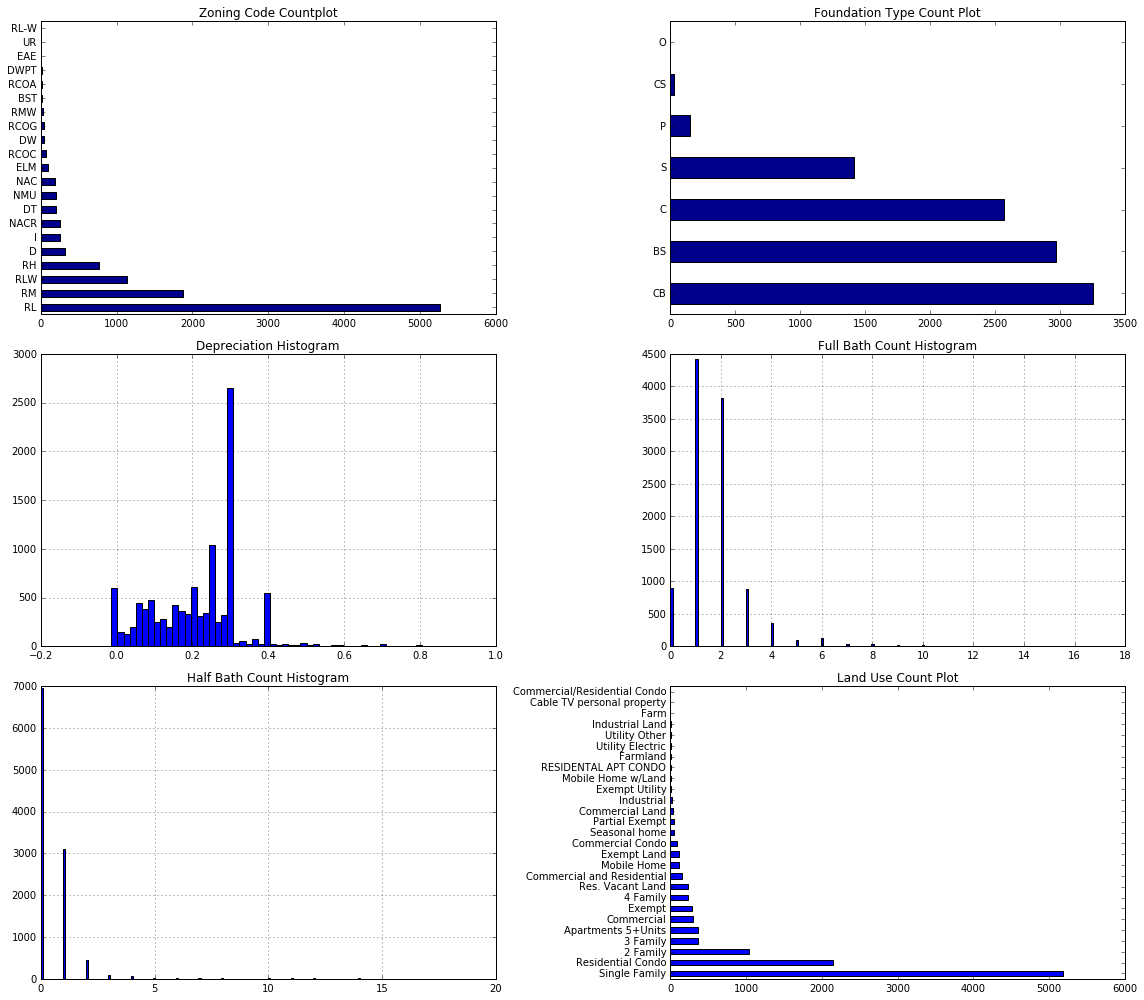

In [3]:
#layout a large plotting grid and plot several important columns
plt.figure(figsize = (16,14))
plt.subplot(321)
df['ZoningCode'].value_counts().plot(kind="barh", color='darkblue')
plt.title('Zoning Code Countplot')
plt.subplot(322)
df['Foundation'].value_counts().plot(kind="barh", color = 'darkblue')
plt.title("Foundation Type Count Plot")
plt.subplot(323)
df['Depreciation'].hist(bins='auto')
plt.title("Depreciation Histogram")
plt.subplot(324)
index = df.loc[:,'Full_Baths'] < 20 
df.Full_Baths[index].hist(bins='auto')
plt.title("Full Bath Count Histogram")
plt.subplot(325)
index = df.loc[:,'Half_Baths'] < 20 
df.Half_Baths[index].hist(bins = 'auto')
plt.title("Half Bath Count Histogram")
plt.subplot(326)
df['LandUse'].value_counts().plot(kind="barh", color ='blue')
plt.title("Land Use Count Plot")
plt.tight_layout()
plt.show()


In [4]:
df.drop('PropertyCenterPoint', 1, inplace = True)

In [5]:
interest = df[['SaleDate', 'SalePrice','CurrentValue', 'Latitude', 'Longitude', 'LandUse', 'YearBlt']].dropna()
interest['SaleDate'] = pd.to_datetime(interest['SaleDate'])
interest = interest[(interest['LandUse'] == "Single Family") | (interest['LandUse'] == "Residential Condo")]
interest = interest[interest['SaleDate'] > pd.to_datetime('1998-12-31')]
interest.set_index('SaleDate', inplace = True)

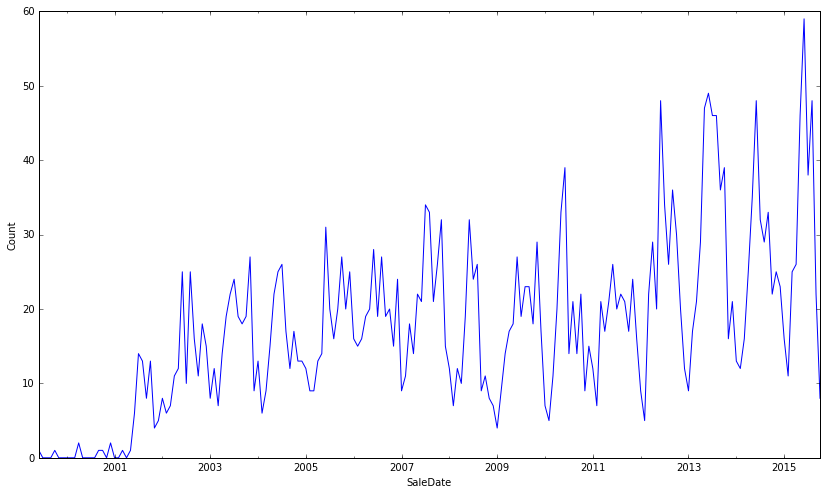

In [6]:
plt.figure(figsize = (14,8))
x = interest.SalePrice.resample('M').count()
x.plot()
plt.ylabel("Count")
plt.show()

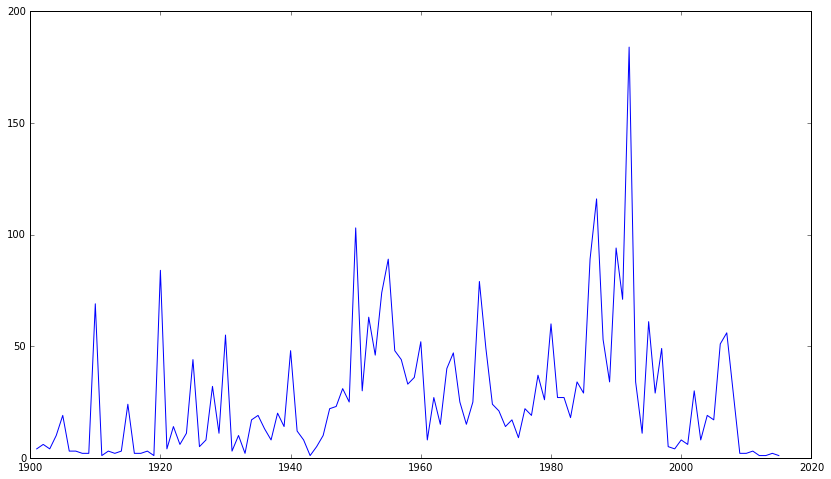

In [7]:
interest = interest[interest['YearBlt'] > 1900]
plt.figure(figsize = (14,8))
y = interest.groupby('YearBlt').count()
plt.plot(y.index, y['Latitude'])
plt.show()

Here I do various type conversions and make some important preprocessing decisions.

* I limit the model to Single Family and Residential Condo Properties

* I restrict the model to only predict Sale Prices less than 800000. 

In [8]:
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
modeldf = df.drop(['AccountNumber', 'ParcelID', 'SpanNumber', 'StreetNumber',
       'AlternateNumber', 'Unit', 'CuO1LastName',
       'CuO1FirstName', 'CuO2LastName', 'CuO2FirstName', 'CuO3LastName',
       'CuO3FirstName','LegalReference', 'GrantorLastName', 'FID', 'Baths'], axis = 1)
modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])
modeldf['Sale_Year'] = modeldf['SaleDate'].apply(lambda row: row.year)
modeldf.drop('SaleDate', axis=1, inplace= True)
modeldf = modeldf[(modeldf['LandUse'] == "Single Family") | (modeldf['LandUse'] == "Residential Condo")]
#modeldf = modeldf[(modeldf['SalePrice'] > 0) & (modeldf['SalePrice'] < 800000)]
modeldf = modeldf[modeldf['SalePrice']> 0]

In [9]:
modeldf.columns

Index(['StreetName', 'LandUse', 'CurrentAcres', 'TotalGrossArea',
       'FinishedArea', 'CurrentValue', 'CurrentLandValue',
       'CurrentYardItemsValue', 'CurrentBuildingValue', 'BuildingType',
       'HeatFuel', 'HeatType', 'Grade', 'YearBlt', 'SalePrice', 'NumofRooms',
       'NumofBedrooms', 'NumofUnits', 'ZoningCode', 'Foundation',
       'Depreciation', 'Latitude', 'Longitude', 'Full_Baths', 'Half_Baths',
       'Sale_Year'],
      dtype='object')

# Modeling

To try to predict Burlington housing pricies I will use a few different supervised learned models.  A supervised learning problem is consists of a target variable Y, in this case 'SalePrice' and a matrix of predictor variables X. The target variable is predicted using the X matrix.  Before fitting an alorgitm to the data I split the data into training and test sets. The purpose behind this is to evaluate the model on data that it has not seen to get a more realistic estimate of it's accuracy.

Predicting Housing 'SalePrice' is a supervised regression problem becasue the target is continuous.


### Decision Tree

Decison trees recursivley break up the sample space to produce estimates and can be visualized with a tree like structure. Decisons trees tend to overfit the training set and not peform super well on test sets.  They are quite powerful models because they can be easily visualized and interpretted by the analyst.

In [10]:
modeldf.dropna(inplace = True)
modeldf = pd.get_dummies(modeldf)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

modeldf['logPrice'] = np.log(modeldf['SalePrice'])
target_name = 'SalePrice'
Xframe = modeldf.drop(['SalePrice', 'logPrice'], axis=1)
data_names = Xframe.columns
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(Xframe)
y=modeldf[target_name]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=123)

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
DecisionTree = tree.DecisionTreeRegressor()
DecisionTree.fit(X_train, y_train)
cv_scores = cross_val_score(DecisionTree, X_train, y_train, cv = 10)
DCTreePrediction = DecisionTree.predict(X_test)

### Decision Tree Cross-Valadation Scores:

In [13]:
#some fit well others don't
for score in cv_scores:
    print(score)
(cv_scores.mean())

0.8035303298525582
0.8275876567067881
0.7694930199074216
0.8825120219667735
0.8088808410453904
0.8599861396940058
0.8436440348171786
0.84929118253772
0.7596849554123091
0.8090852955153959


0.8213695477455542

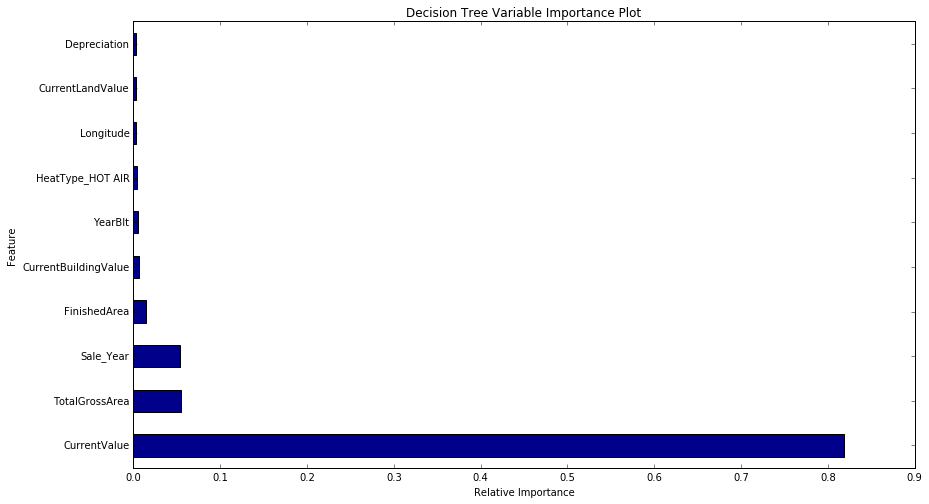

In [14]:
#Importance plot 
columnNames = Xframe.columns
importances = DecisionTree.feature_importances_
combined = {'Feature': columnNames, 'imp': importances}
imp = pd.DataFrame(data=combined).sort_values(by = ['imp'], ascending=False)

imp.iloc[0:10,:].plot(x = 'Feature', y= 'imp',kind='barh', legend = False, figsize = (14,8), color = "darkblue")
plt.title("Decision Tree Variable Importance Plot")
plt.xlabel("Relative Importance")
plt.show()

### Random Forest 

The Random Forest algorithm fits multiple decision trees on bootstrapped samples of the training set data.  The predicted value is the mean of all teh trees end nodes.  Random forests tend to much better on test sets than decision trees.  The Random Forest is my personal favorite supervised machine learing algorithm.

In [15]:
from sklearn.ensemble  import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
rfmodel = RandomForestRegressor()
rfmodel.fit(X_train, y_train)
cv_scores = cross_val_score(rfmodel, X_train, y_train, cv = 10)
rfpmodel = rfmodel.predict(X_test)

/Users/bryant/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
#some fit well others don't
for score in cv_scores:
    print(score)
(cv_scores.mean())

0.8969409697342938
0.8710870629959958
0.8728919938211317
0.8885928925858142
0.8933177856036818
0.7922140228457477
0.9010988467164984
0.8948110584470129
0.8824647581085229
0.8694826931203626


0.8762902083979063

### Random Forest Random Search

Here I attempt to tune the random forest's hyperperamters.  Hyperperamters are external model peramters that control how it fits to the data. Tuning peramters correctly increases accuracy and fights overfitting.

In [17]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"max_depth": [3, None, 5, 10 ,15, 30],
              "max_features": sp_randint(1, 30),
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 30),
              "bootstrap": [True, False]}
              

# run randomized search
n_iter = 100
random_search = RandomizedSearchCV(rfmodel, cv = 3, param_distributions=param_dist,
                                   n_iter=n_iter, n_jobs=-1)
random_search.fit(X_train, y_train)
bestmodel = random_search.best_estimator_
random_search_pred = bestmodel.predict(X_test)

In [18]:
params_rf = {'n_estimators' : [100, 350, 500],
            'max_features': ['log2', 'auto', 'sqrt'],
            'min_samples_leaf': [2, 10, 30]}
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rfmodel,
                       param_grid=params_rf,
                       cv=3,
                       verbose=0,
                       n_jobs=-1)

grid_rf.fit(X_train,y_train)
bestmodel = grid_rf.best_estimator_
random_search_pred = bestmodel.predict(X_test)

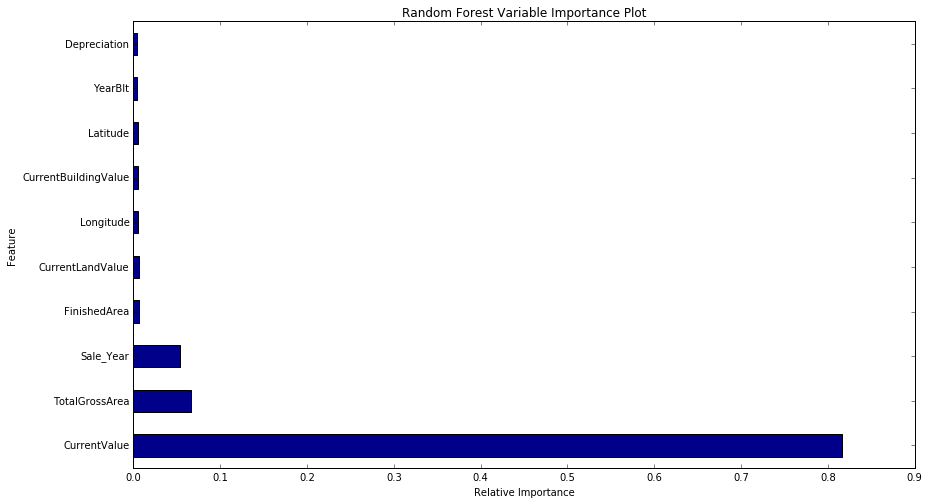

In [19]:
#Importance plot 
columnNames = Xframe.columns
importances = bestmodel.feature_importances_
combined = {'Feature': columnNames, 'imp': importances}
imp = pd.DataFrame(data=combined).sort_values(by = ['imp'], ascending=False)

imp.iloc[0:10,:].plot(x = 'Feature', y= 'imp',kind='barh', legend = False, figsize = (14,8),color='darkblue')
plt.title("Random Forest Variable Importance Plot")
plt.xlabel("Relative Importance")
plt.show()

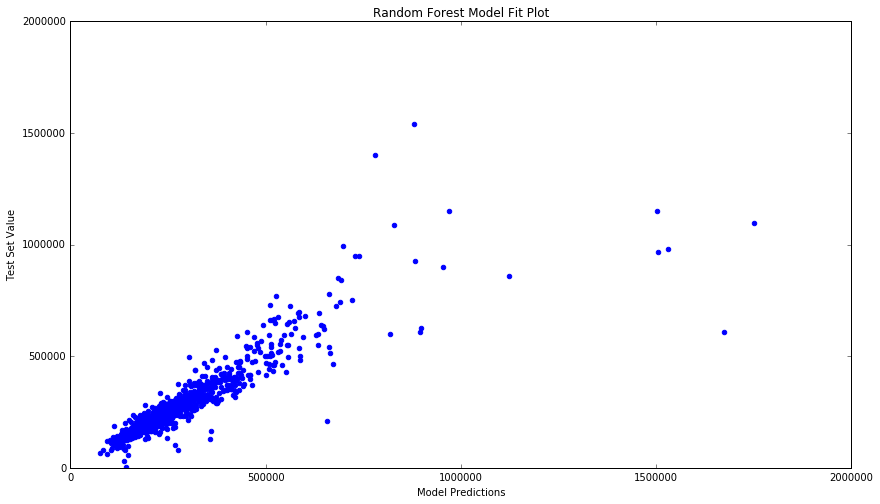

In [20]:
plt.figure(figsize = (14,8))
plt.scatter(rfpmodel, y_test, color = 'b')
#plt.plot([rfpmodel.min(), rfpmodel.max()], [y_test.min(), y_test.max()], 'k--', lw=6)
plt.ylabel("Test Set Value")
plt.xlabel("Model Predictions")
plt.xlim(0, 2000000)
plt.ylim(0, 2000000)
plt.title("Random Forest Model Fit Plot")
plt.show()

### Gradient Boosted Tree Model

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=500).fit(X_train, y_train)

clf.score(X_test, y_test)

cv_scores = cross_val_score(clf, X_train,y_train,n_jobs=-1, cv = 10)
gradient_score = clf.predict(X_test)
for score in cv_scores:
    print(score)
print("mean score:", np.mean(cv_scores))

0.893444746571232
0.8130400108037854
0.877257204806986
0.9285590666662835
0.9018707517412357
0.8828905648941111
0.9116722411387632
0.8903650794543629
0.894759640551297
0.8655014127837521
mean score: 0.8859360719411811


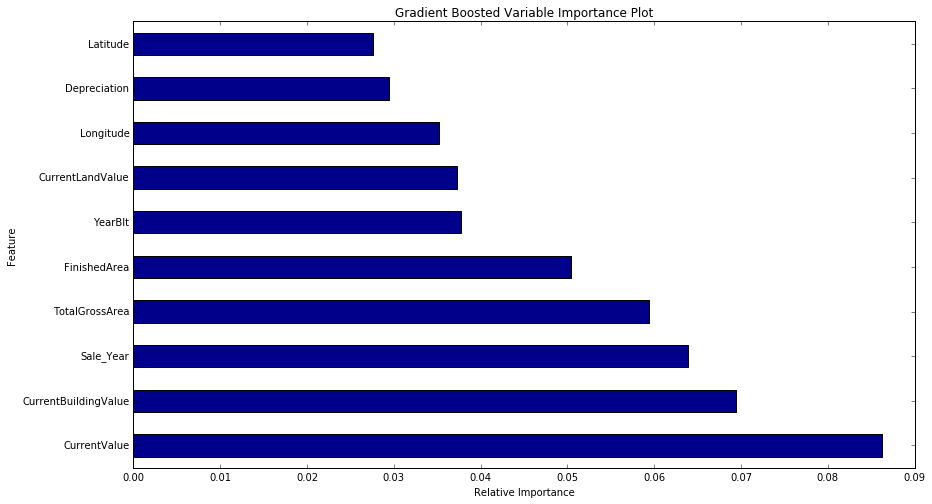

In [22]:
#Importance plot 
columnNames = Xframe.columns
importances = clf.feature_importances_
combined = {'Feature': columnNames, 'imp': importances}
imp = pd.DataFrame(data=combined).sort_values(by = ['imp'], ascending=False)

imp.iloc[0:10,:].plot(x = 'Feature', y= 'imp',kind='barh', legend = False, figsize = (14,8), color='darkblue')
plt.title("Gradient Boosted Variable Importance Plot")
plt.xlabel("Relative Importance")
plt.show()

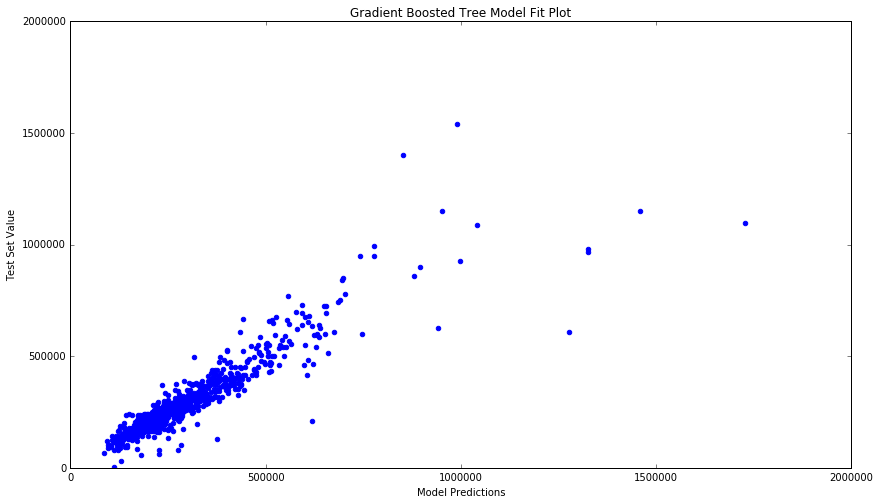

In [23]:
plt.figure(figsize = (14,8))
plt.scatter(gradient_score, y_test, color = 'b')
#plt.plot([gradient_score.min(), gradient_score.max()], [y_test.min(), y_test.max()], 'k--', lw=6)
plt.ylabel("Test Set Value")
plt.xlabel("Model Predictions")
plt.title("Gradient Boosted Tree Model Fit Plot")
plt.xlim(0, 2000000)
plt.ylim(0, 2000000)
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, DCTreePrediction))
print("Decision Tree RMSE:", rms)

rms = sqrt(mean_squared_error(y_test, rfpmodel))
print("Random Forest RMSE:", rms)

rms = sqrt(mean_squared_error(y_test, random_search_pred))
print("Tuned Random Forest RMSE:", rms)

rms = sqrt(mean_squared_error(y_test, gradient_score))
print("Boosted Tree RMSE:", rms)


Decision Tree RMSE: 97069.89709011797
Random Forest RMSE: 84062.61707035844
Tuned Random Forest RMSE: 83005.67614500881
Boosted Tree RMSE: 71754.93349490696


In [25]:
np.mean(np.abs((y_test - gradient_score) / y_test)) * 100

16.313671834394732